# Simulating and Identifying a Quadratic Boost Converter using PLECS and Python

This document walks through the process of simulating a quadratic boost converter in PLECS, retrieving the simulation data, performing system identification using a data-driven polynomial modeling approach.


### 1. Prerequisites and Imports

First, we need to import the necessary Python libraries.

- `xmlrpc.clien`t is used to communicate with the PLECS simulation software.

- `matplotlib.pyplot` is for plotting graphs.

- `numpy` is for numerical operations, especially array manipulation.

- `cvxpy` is a modeling language for convex optimization problems.

- `sklearn.preprocessing` and `sklearn.linear_model` are used for polynomial regression.


In [7]:
import xmlrpc.client as xml
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

### 2. PLECS Connection and Simulation Setup

We establish a connection to the PLECS XML-RPC server and define the model name.


In [8]:
# Establish connection with PLECS
plecs = xml.Server("http://localhost:9998/RPC2").plecs

# Define the PLECS model name
model = 'quadratic_boost_converter_identification'
# file_type = '.plecs' # File type, if needed for other operations

**Note**: Ensure PLECS is running and the XML-RPC server is enabled at the specified address and port.


### 3. Data Acquisition from PLECS

Simulate the PLECS model and retrieve the time, input, and output data.


In [9]:
# Simulate the model and get raw data
simulation_results = plecs.simulate(model)
time_raw = np.array(simulation_results['Time'])
input_raw = np.array(simulation_results['Values'][0]) # Assuming first output is input current/signal
output_raw = np.array(simulation_results['Values'][1]) # Assuming second output is output voltage

# Other measures
iL1_raw = np.array(simulation_results['Values'][2])
iL2_raw = np.array(simulation_results['Values'][3])
VC1_raw = np.array(simulation_results['Values'][4])
VC2_raw = np.array(simulation_results['Values'][5])

np.savez('identification_data.npz',
         time=time_raw,
         input=input_raw,
         output=output_raw,
         iL1=iL1_raw,
         iL2=iL2_raw,
         VC1=VC1_raw,
         VC2=VC2_raw)

In [10]:
#identification_data = np.load('identification_data.npz')

#time_raw = identification_data['time']
#input_raw = identification_data['input']
#output_raw = identification_data['output']
#iL1_raw = identification_data['iL1']
#iL2_raw = identification_data['iL2']
#VC1_raw = identification_data['VC1']
#VC2_raw = identification_data['VC2']

### 4. Data Preprocessing: Downsampling

The raw simulation data might be too dense. We define a function to downsample the data by averaging, which can help in reducing computation time for subsequent analysis and smoothing out noise.


In [11]:
def downsample_average(arr, factor):
    """
    Downsamples an array by averaging consecutive elements.
    Args:
        arr (np.array): The input array.
        factor (int): The downsampling factor.
    Returns:
        np.array: The downsampled array.
    """
    # Ensure the array length is a multiple of the factor
    end_index = len(arr) - (len(arr) % factor)
    return arr[:end_index].reshape(-1, factor).mean(axis=1)

# Downsample the data
downsample_factor = 1000
output_resampled = downsample_average(output_raw, factor=downsample_factor)
input_resampled = downsample_average(input_raw, factor=downsample_factor)
time_resampled = downsample_average(time_raw, factor=downsample_factor)

iL1_resampled = downsample_average(iL1_raw, factor=downsample_factor)
iL2_resampled = downsample_average(iL2_raw, factor=downsample_factor)
VC1_resampled = downsample_average(VC1_raw, factor=downsample_factor)
VC2_resampled = downsample_average(VC2_raw, factor=downsample_factor)

### 5. Initial Data Visualization

Let's plot the downsampled input and output signals to get a visual understanding of the system's behavior.


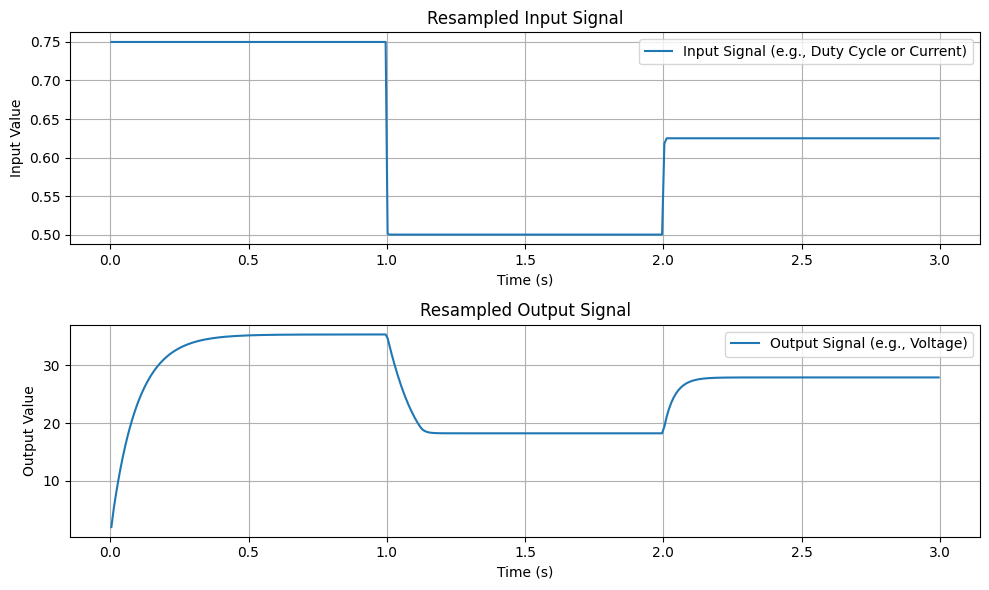

In [12]:
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(time_resampled, input_resampled, label='Input Signal (e.g., Duty Cycle or Current)')
plt.title('Resampled Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time_resampled, output_resampled, label='Output Signal (e.g., Voltage)')
plt.title('Resampled Output Signal')
plt.xlabel('Time (s)')
plt.ylabel('Output Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

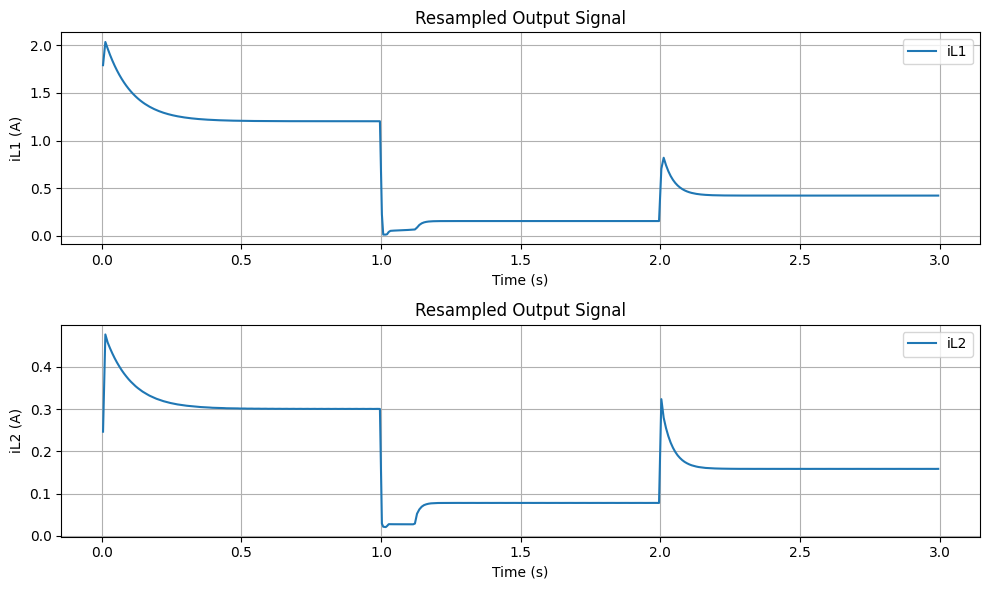

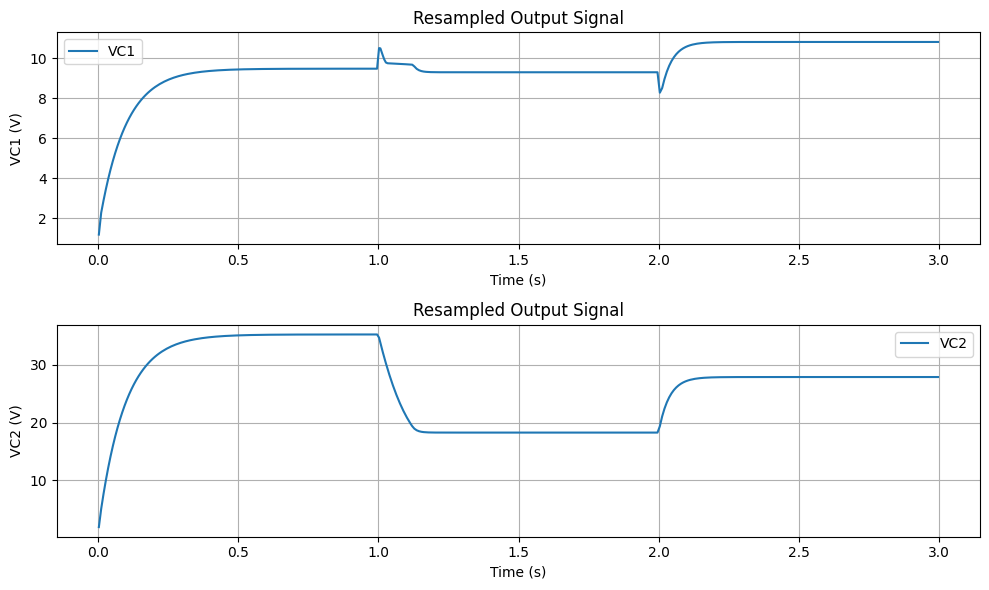

In [13]:
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(time_resampled, iL1_resampled, label='iL1')
plt.title('Resampled Output Signal')
plt.xlabel('Time (s)')
plt.ylabel('iL1 (A)')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time_resampled, iL2_resampled, label='iL2')
plt.title('Resampled Output Signal')
plt.xlabel('Time (s)')
plt.ylabel('iL2 (A)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(time_resampled, VC1_resampled, label='VC1')
plt.title('Resampled Output Signal')
plt.xlabel('Time (s)')
plt.ylabel('VC1 (V)')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time_resampled, VC2_resampled, label='VC2')
plt.title('Resampled Output Signal')
plt.xlabel('Time (s)')
plt.ylabel('VC2 (V)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 6. System Identification: Data-Driven Polynomial Modeling

We aim to identify a polynomial model of the form:

$$ Y\_{k+1} = A \cdot Z_k + B \cdot W_k $$

where $Y_k$ is the output, $W_k$ is the input, and $Z_k$ is a state vector potentially including non-linear terms of the output (e.g., $Y_k$, $Y_k^2$, $Y_k^3$)

We use `cvxpy` to solve the optimization problem for finding matrices A and B that minimize the prediction error.


In [14]:
def system_identification(Y, U, poly_terms, solver=cp.CLARABEL):
    """
    Perform system identification using explicitly chosen polynomial terms.

    Parameters
    ----------
    Y : np.ndarray
        Output data, shape (n_outputs, n_samples) or (n_samples,) for single output.
    U : np.ndarray
        Input data, shape (n_inputs, n_samples) or (n_samples,) for single input.
    poly_terms : list of tuples
        Each tuple defines the exponents for one monomial in the outputs.
        Example for 2 outputs: (2,0) -> Y1^2 ; (1,1) -> Y1*Y2 ; (0,2) -> Y2^2
    solver : str
        CVXPY solver to use (default: CLARABEL).

    Returns
    -------
    A_identified : np.ndarray
        Identified A matrix (output regression coefficients).
    B_identified : np.ndarray
        Identified B matrix (input regression coefficients).
    """

    # Ensure correct shapes
    if Y.ndim == 1:
        Y = Y[np.newaxis, :]  # (1, N)
    if U.ndim == 1:
        U = U[np.newaxis, :]  # (1, N)

    n_outputs, N = Y.shape
    n_inputs, _ = U.shape

    # Build custom polynomial regressors
    Z_terms = []
    for exp_tuple in poly_terms:
        if len(exp_tuple) != n_outputs:
            raise ValueError("Each poly_terms tuple must match number of outputs")
        term = np.prod([Y[i, :-1]**exp_tuple[i] for i in range(n_outputs)], axis=0)
        Z_terms.append(term)

    Z_matrix = np.vstack(Z_terms)  # (n_terms, N-1)
    W_matrix = U[:, :-1]           # (n_inputs, N-1)
    YY_vector = Y[:, 1:]           # (n_outputs, N-1)

    # Define CVXPY variables
    A_param = cp.Variable((n_outputs, Z_matrix.shape[0]))
    B_param = cp.Variable((n_outputs, n_inputs))

    # Cost function
    cost_function = cp.norm2(YY_vector - (A_param @ Z_matrix + B_param @ W_matrix))
    problem = cp.Problem(cp.Minimize(cost_function))
    problem.solve(solver=solver)

    return A_param.value, B_param.value

# Single-output (ARX-like) with terms Y, Y^2, Y^3
poly_terms_single = [(1,), (2,), (3,)]
A, B = system_identification(output_resampled, input_resampled, poly_terms_single)

# Two outputs: include Y1, Y1^2, Y2, Y2^2, and Y1*Y2
#poly_terms_multi = [(1,0), (2,0), (0,1), (0,2), (1,1)]
#Y_multi = np.vstack((output_resampled, iL1_resampled))
#A, B = system_identification(Y_multi, input_resampled, poly_terms_multi)

print("Identified A matrix:", A)
print("Identified B matrix:", B)

Identified A matrix: [[ 7.42885565e-01  8.13935444e-03 -1.16452826e-04]]
Identified B matrix: [[5.39397645]]


### 7. Simulating the Identified Polynomial Model

Now, we use the identified matrices `A` and `B` to simulate the system's response to a predefined input sequence. This helps validate the identified model.


In [15]:
# Initial conditions for the model simulation
y_poly_current = 0  # Initial output
u_poly_current = 0.75 # Initial input

# Arrays to store the simulated model output and input
Y = np.array([])
U = np.array([])

# Simulate step-by-step using the identified model
for t_step in time_resampled:
    # Prepare W_d (input vector for model)
    W_d_step = np.array([u_poly_current])
    # Prepare Z_d (state vector for model)
    Z_d_step = np.array([y_poly_current, y_poly_current**2, y_poly_current**3])

    # Predict next output using the identified model
    y_poly_next = A @ Z_d_step + B @ W_d_step
    y_poly_current = y_poly_next[0] # Update current output

    # Store results
    Y = np.append(Y, y_poly_current)
    U = np.append(U, u_poly_current)

    # Change input u_poly_current at specific time points for testing
    if t_step >= 1.0 and t_step < 2.0: # Time check should be robust
        u_poly_current = 0.5
    elif t_step >= 2.0:
        u_poly_current = 0.625

**Note**: The length of `Y` and `U` will match `time_resampled`.


### 8. Visualizing Polynomial Model Performance

Compare the output of the identified polynomial model with the actual resampled output from PLECS. Also, plot the error between them.


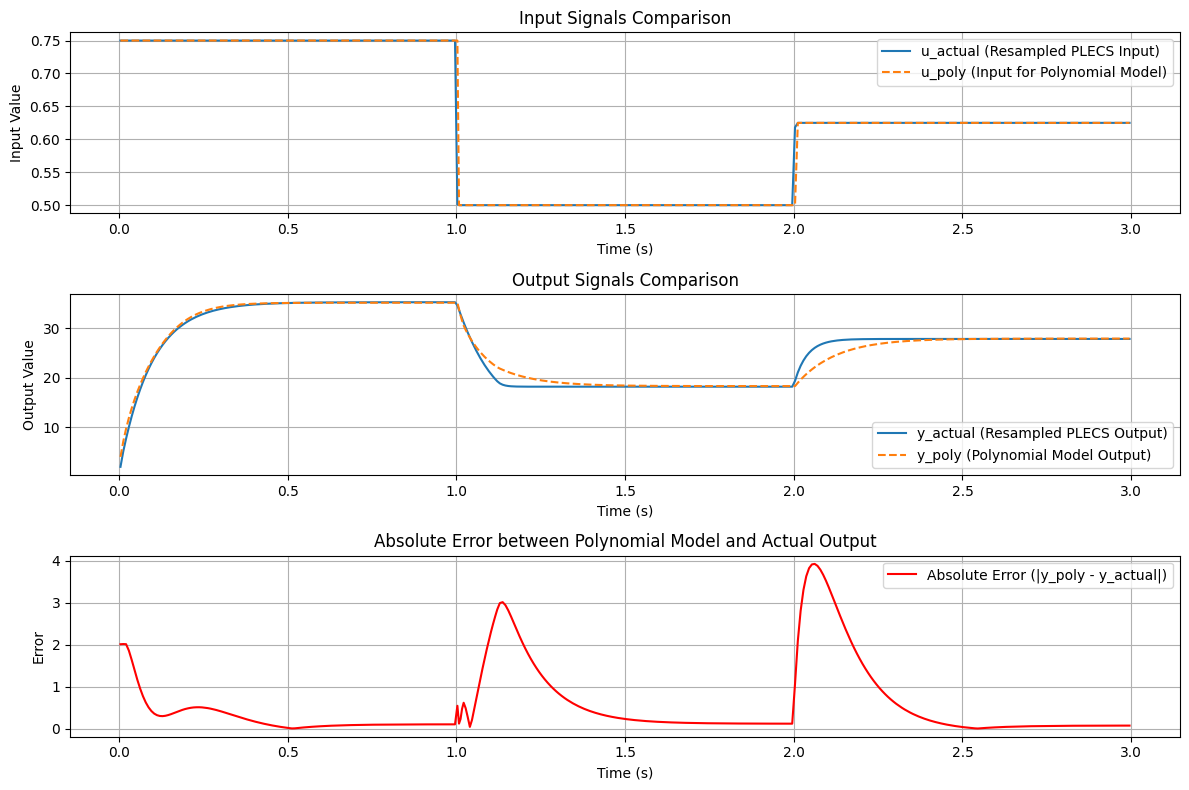

In [16]:
plt.figure(figsize=(12, 8))

# Plot Input Signals
plt.subplot(3,1,1)
plt.plot(time_resampled, input_resampled, label='u_actual (Resampled PLECS Input)')
plt.plot(time_resampled, U, label='u_poly (Input for Polynomial Model)', linestyle='--')
plt.title('Input Signals Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
plt.legend()
plt.grid(True)

# Plot Output Signals
plt.subplot(3,1,2)
plt.plot(time_resampled, output_resampled, label='y_actual (Resampled PLECS Output)')
plt.plot(time_resampled, Y, label='y_poly (Polynomial Model Output)', linestyle='--')
plt.title('Output Signals Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Output Value')
plt.legend()
plt.grid(True)

# Plot Error
plt.subplot(3,1,3)
# Ensure lengths match for error calculation if Y has different length
min_len = min(len(Y), len(output_resampled))
error = np.abs(Y[:min_len] - output_resampled[:min_len])
plt.plot(time_resampled[:min_len], error, label='Absolute Error (|y_poly - y_actual|)', color='red')
plt.title('Absolute Error between Polynomial Model and Actual Output')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 9. Static Input-Output Mapping

This code creates a simplified **static model** from a system's dynamic simulation.

First, it simulates the system's response to a staircase input signal, where the input is held at several constant levels. By capturing the final, settled output value at the end of each input step, it collects a set of **steady-state** input-output data points (`U_steps`, `Y_steps`).

Next, it uses **polynomial interpolation** (`np.polyfit`) to fit a continuous function through these discrete points. The result is a single polynomial equation, $Y_{ss} = P(U_{ss})$, that serves as a static map, predicting the final output for any constant input within the tested range while ignoring the system's transient dynamics.


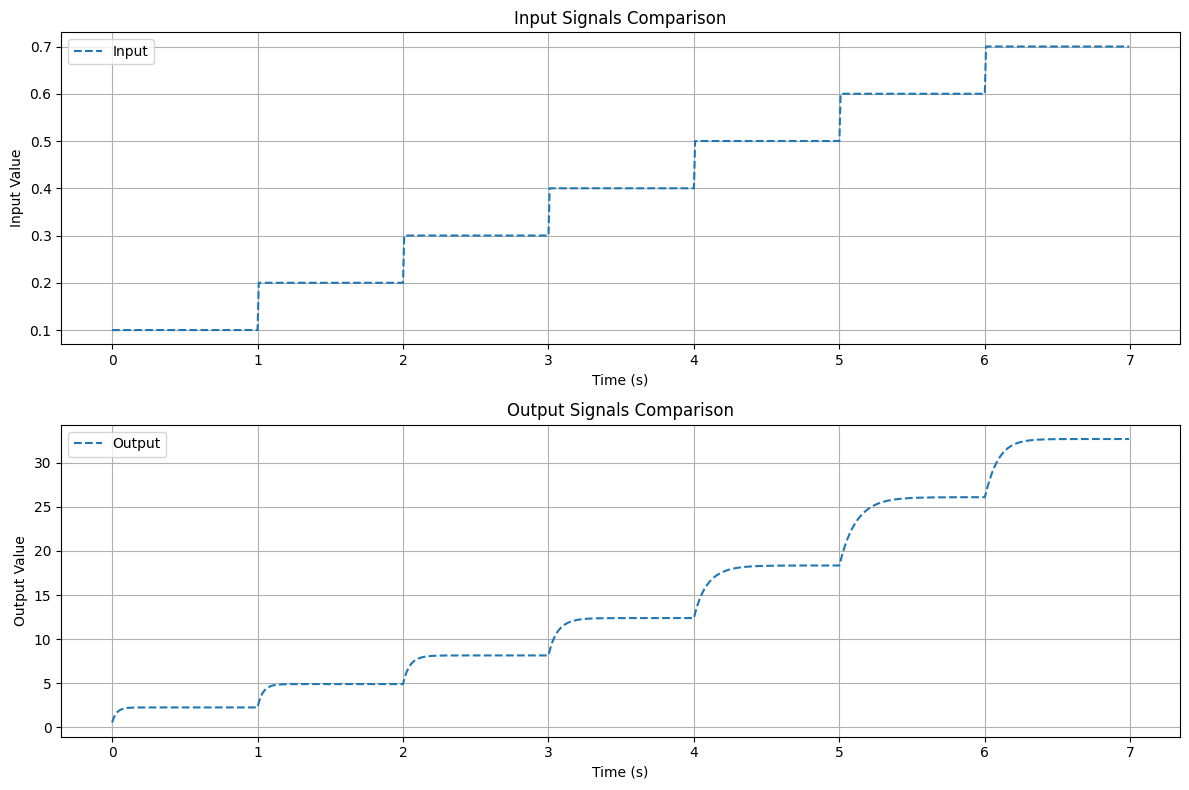

Polynomial coefficients (highest degree first):
[-1.79665964e+03  2.92248221e+03 -1.72466040e+03  5.18946213e+02
 -5.92253490e+01  2.58843979e+01 -1.16633474e-01]

Polynomial equation:
       6        5        4         3         2
-1797 x + 2922 x - 1725 x + 518.9 x - 59.23 x + 25.88 x - 0.1166

Verification at original points:
X=0.1 -> Y_actual=2.25, Y_pred=2.253461
X=0.2 -> Y_actual=4.90, Y_pred=4.903553
X=0.3 -> Y_actual=8.15, Y_pred=8.152070
X=0.4 -> Y_actual=12.39, Y_pred=12.389421
X=0.5 -> Y_actual=18.35, Y_pred=18.350992
X=0.6 -> Y_actual=26.10, Y_pred=26.096538
X=0.7 -> Y_actual=32.70, Y_pred=32.695988


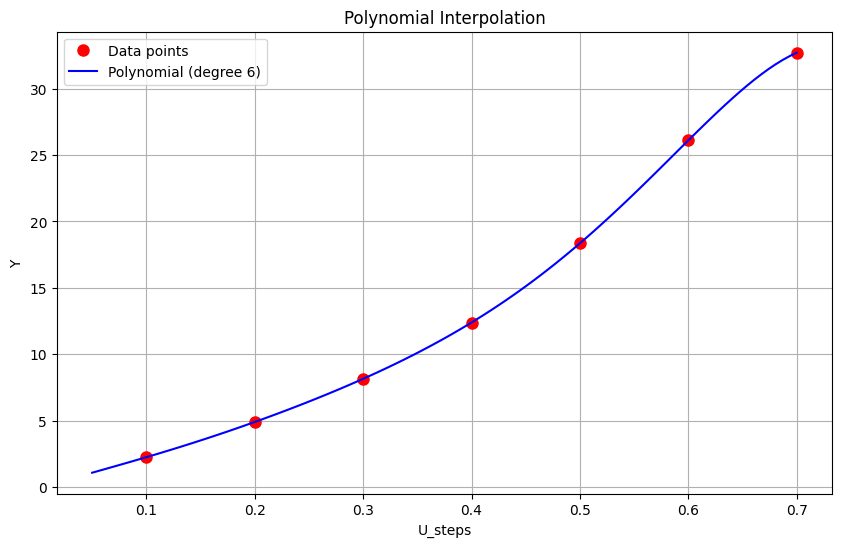

In [17]:
# Initial conditions for the model simulation
y = 0  # Initial output
u = 0.1 # Initial input

# Arrays to store the simulated model output and input (amostras completas)
Y = np.array([])
U = np.array([])

# Arrays para armazenar o valor final de cada patamar (mapa entrada → saída)
Y_steps = []
U_steps = []

time_sampled = np.arange(0, 7, 0.008)

# Simulate step-by-step using the identified model
for i, t_step in enumerate(time_sampled):
    # Prepare W_d (input vector for model)
    W_d_step = np.array([u])
    # Prepare Z_d (state vector for model)
    Z_d_step = np.array([y, y**2, y**3])

    # Predict next output using the identified model
    y = A @ Z_d_step + B @ W_d_step
    y = y[0] # Update current output

    # Store full trajectory
    Y = np.append(Y, y)
    U = np.append(U, u)

    # Store the last value of Y in the input step
    if abs((t_step + 0.008) % 1.0) < 1e-9: 
        Y_steps.append(float(y))
        U_steps.append(u)

    # Change input u at specific time points
    if t_step >= 1.0 and t_step < 2.0: 
        u = 0.2
    elif t_step >= 2.0 and t_step < 3.0:
        u = 0.3
    elif t_step >= 3.0 and t_step < 4.0:
        u = 0.4
    elif t_step >= 4.0 and t_step < 5.0:
        u = 0.5
    elif t_step >= 5.0 and t_step < 6.0:
        u = 0.6
    elif t_step >= 6.0 and t_step < 7.0:
        u = 0.7   

plt.figure(figsize=(12, 8))

# Plot Input Signals
plt.subplot(2,1,1)
plt.plot(time_sampled, U, label='Input', linestyle='--')
plt.title('Input Signals Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
plt.legend()
plt.grid(True)

# Plot Output Signals
plt.subplot(2,1,2)
plt.plot(time_sampled, Y, label='Output', linestyle='--')
plt.title('Output Signals Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Output Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Given data
U_steps = np.array(U_steps)
Y_steps = np.array(Y_steps)

# Fit polynomial (degree 5 for 7 points gives perfect fit)
degree = len(U_steps) - 1
coefficients = np.polyfit(U_steps, Y_steps, degree)

# Create polynomial function
polynomial = np.poly1d(coefficients)

# Print the polynomial
print("Polynomial coefficients (highest degree first):")
print(coefficients)
print(f"\nPolynomial equation:")
print(polynomial)

# Evaluate at original points to verify
print(f"\nVerification at original points:")
for i, x in enumerate(U_steps):
    y_pred = polynomial(x)
    print(f"X={x:.1f} -> Y_actual={Y_steps[i]:.2f}, Y_pred={y_pred:.6f}")

# Plot the results
x_fine = np.linspace(0.05, 0.7, 100)
y_fine = polynomial(x_fine)

plt.figure(figsize=(10, 6))
plt.plot(U_steps, Y_steps, 'ro', markersize=8, label='Data points')
plt.plot(x_fine, y_fine, 'b-', label=f'Polynomial (degree {degree})')
plt.xlabel('U_steps')
plt.ylabel('Y')
plt.title('Polynomial Interpolation')
plt.legend()
plt.grid(True)
plt.show()

# Function to predict Y for any X
def predict_y(x_value):
    return polynomial(x_value)

### 10. Controlled PLECS Simulation

Simulate the PLECS controlled system.


In [18]:
# Establish connection with PLECS
plecs = xml.Server("http://localhost:9998/RPC2").plecs

# Define the PLECS model name
model = 'quadratic_boost_converter_control'
# file_type = '.plecs' # File type, if needed for other operations

# Simulate the model and get raw data
simulation_results = plecs.simulate(model)
time = np.array(simulation_results['Time'])
input = np.array(simulation_results['Values'][0]) 
output = np.array(simulation_results['Values'][1]) 
load = np.array(simulation_results['Values'][6]) 

# Other measures
iL1 = np.array(simulation_results['Values'][2])
iL2 = np.array(simulation_results['Values'][3])
VC1 = np.array(simulation_results['Values'][4])
VC2= np.array(simulation_results['Values'][5])

np.savez('control_data.npz',
         time=time,
         input=input,
         output=output,
         load=load,
         iL1=iL1,
         iL2=iL2,
         VC1=VC1,
         VC2=VC2)

In [19]:
#control_data = np.load('control_data.npz')

#time= control_data['time']
#input= control_data['input']
#output = control_data['output']
#load = control_data['load']
#iL1 = control_data['iL1']
#iL2 = control_data['iL2']
#VC1 = control_data['VC1']
#VC2 = control_data['VC2']

In [20]:
downsample_factor = 1000
output = downsample_average(output, factor=downsample_factor)
load = downsample_average(load, factor=downsample_factor)
input = downsample_average(input, factor=downsample_factor)
time = downsample_average(time, factor=downsample_factor)

iL1 = downsample_average(iL1, factor=downsample_factor)
iL2 = downsample_average(iL2, factor=downsample_factor)
VC1 = downsample_average(VC1, factor=downsample_factor)
VC2 = downsample_average(VC2, factor=downsample_factor)

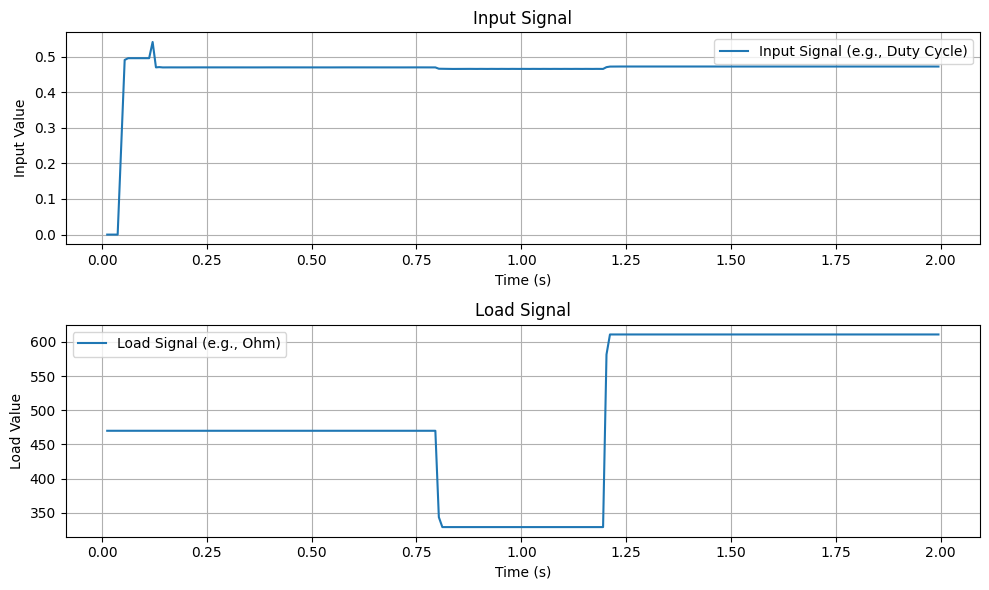

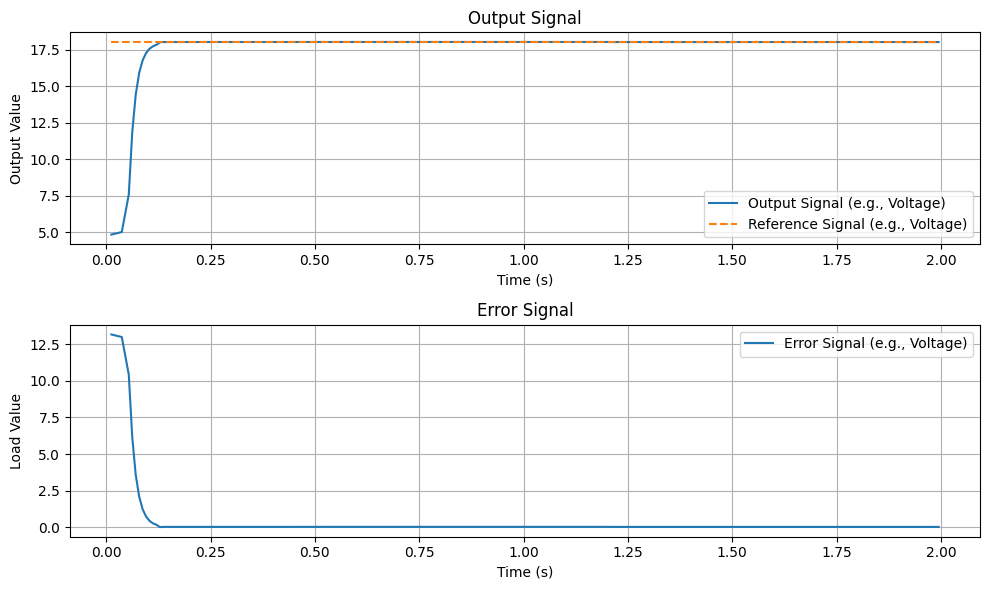

In [21]:
ref_value = 18

plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(time, input, label='Input Signal (e.g., Duty Cycle)')
plt.title('Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, load, label='Load Signal (e.g., Ohm)')
plt.title('Load Signal')
plt.xlabel('Time (s)')
plt.ylabel('Load Value')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(time, output, label='Output Signal (e.g., Voltage)')
plt.plot(time, np.full_like(output, ref_value), '--', label='Reference Signal (e.g., Voltage)')
plt.title('Output Signal')
plt.xlabel('Time (s)')
plt.ylabel('Output Value')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, np.abs(output - np.full_like(output, ref_value)), label='Error Signal (e.g., Voltage)')
plt.title('Error Signal')
plt.xlabel('Time (s)')
plt.ylabel('Load Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

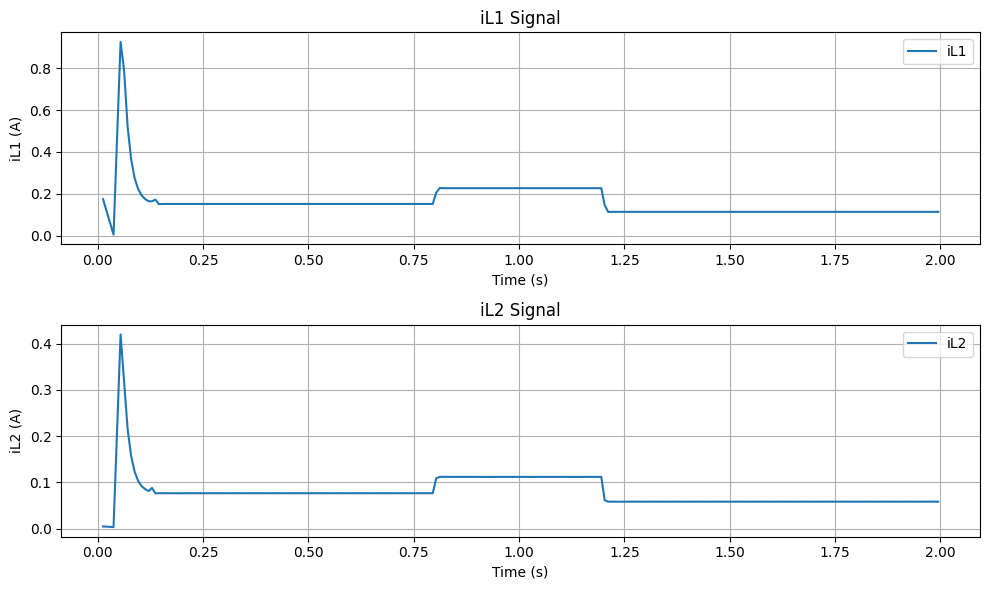

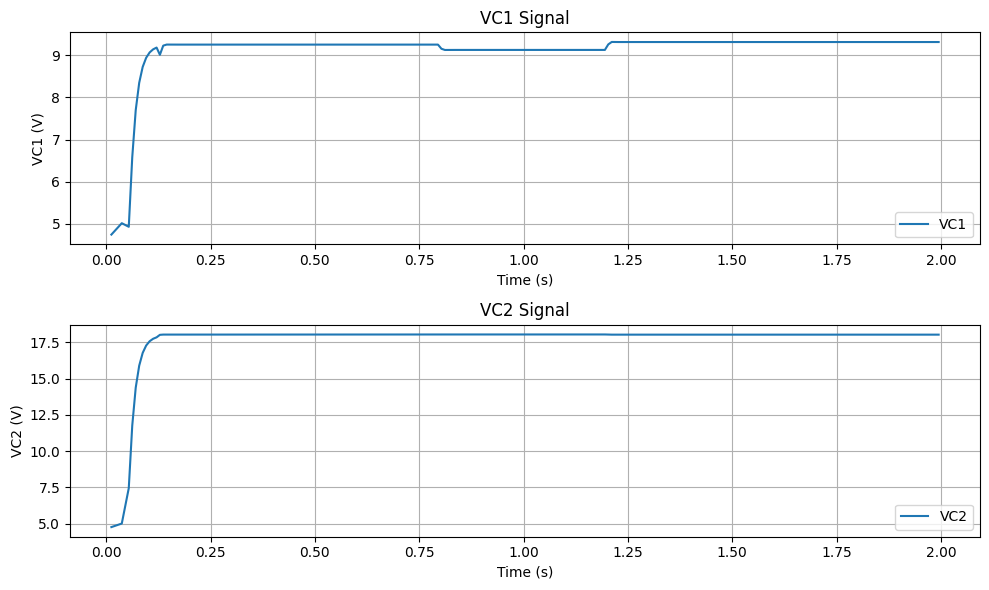

In [22]:
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(time, iL1, label='iL1')
plt.title('iL1 Signal')
plt.xlabel('Time (s)')
plt.ylabel('iL1 (A)')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, iL2, label='iL2')
plt.title('iL2 Signal')
plt.xlabel('Time (s)')
plt.ylabel('iL2 (A)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(time, VC1, label='VC1')
plt.title('VC1 Signal')
plt.xlabel('Time (s)')
plt.ylabel('VC1 (V)')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, VC2, label='VC2')
plt.title('VC2 Signal')
plt.xlabel('Time (s)')
plt.ylabel('VC2 (V)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()